## STDP update dynamics

Hebbian rule from 0 to t

Anti-hebbian rule from -t to 0


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from spikey.synapse import RLSTDP as SYNAPSE
from spikey.neuron import Neuron as NEURONS

In [2]:
class FakeWeight:
    def __init__(self, **config):
        self._matrix = np.zeros((config['n_inputs'] + config['n_neurons'], config['n_neurons']))
        self.matrix = self._matrix

    def clip(self):
        pass

In [3]:
def onehot(value, buckets):
    output = np.zeros(buckets)
    output[value] = 1
    return output

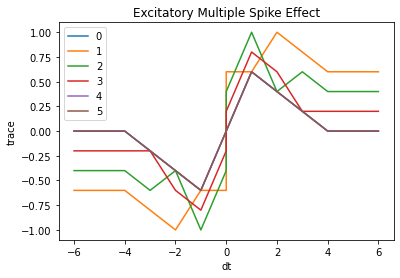

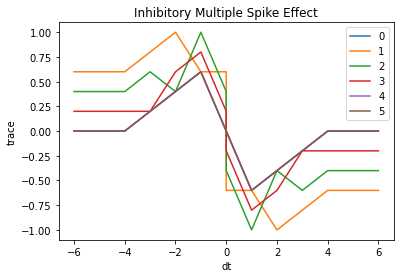

In [4]:
## Excitatory vs Inhibitory
config = {
    'n_neurons': 2,
    'n_inputs': 0,
    'stdp_window': 5,
    'learning_rate': 1,
    'max_weight': 1,
    'trace_decay': 0,
}
w = FakeWeight(**config)
synapses = SYNAPSE(w, **config)

LENGTH = config['stdp_window'] + 1

for plot_id, (label, INHIBITORIES) in enumerate({'Excitatory': [1, 1], 'Inhibitory': [-1, -1]}.items(), 1):
    INHIBITORIES = np.array(INHIBITORIES)

    for j in range(LENGTH):
        X, X_minus, Y, Y_minus = [], [], [], []

        for i in range(LENGTH + 1):
            w.matrix[:, :] = 0
            synapses.reset()
            synapses.reward(1)

            a = np.zeros(LENGTH)
            a[-1] = 1

            b = onehot(LENGTH - i - 1, LENGTH)
            b[LENGTH - j - 1] = 1

            full_spike_log = np.array([a, b]).T
            synapses._apply_stdp(full_spike_log, INHIBITORIES)

            X_minus.append(-i)
            Y_minus.append(w.matrix[0, 1])
            X.append(i)
            Y.append(w.matrix[1, 0])

        plt.plot(X_minus[::-1] + X, Y_minus[::-1] + Y, label=j)

    plt.title(f"{label} Multiple Spike Effect")
    plt.xlabel('dt')
    plt.ylabel('trace')
    plt.legend()
    plt.show()

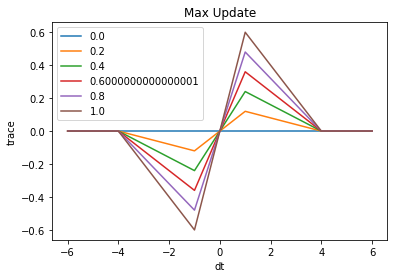

In [5]:
## Max Update
INHIBITORIES = np.array([1, 1])

for j in np.arange(0, 1.1, .2):
    config = {
        'n_neurons': 2,
        'n_inputs': 0,
        'stdp_window': 5,
        'learning_rate': j,
        'max_weight': 1,
        'trace_decay': 0,
    }
    w = FakeWeight(**config)
    synapses = SYNAPSE(w, **config)

    X, X_minus, Y, Y_minus = [], [], [], []

    LENGTH = config['stdp_window'] + 1

    for i in range(LENGTH + 1):
        w.matrix[:, :] = 0
        synapses.reset()
        synapses.reward(1)

        a = np.zeros(LENGTH)
        a[-1] = 1

        b = onehot(LENGTH - i - 1, LENGTH)

        full_spike_log = np.array([a, b]).T

        synapses._apply_stdp(full_spike_log, INHIBITORIES)

        X_minus.append(-i)
        Y_minus.append(w.matrix[0, 1])
        X.append(i)
        Y.append(w.matrix[1, 0])

    plt.plot(X_minus[::-1] + X, Y_minus[::-1] + Y, label=j)

plt.title('Max Update')
plt.xlabel('dt')
plt.ylabel('trace')
plt.legend()

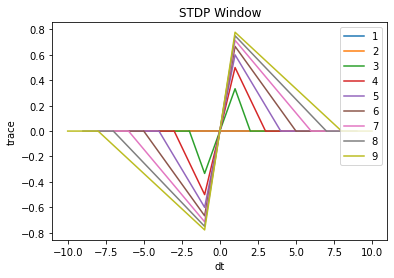

In [6]:
## Window
INHIBITORIES = np.array([1, 1])

for j in range(1, 10):
    config = {
        'n_neurons': 2,
        'n_inputs': 0,
        'stdp_window': j,
        'learning_rate': 1,
        'max_weight': 1,
        'trace_decay': 0,
    }
    w = FakeWeight(**config)
    synapses = SYNAPSE(w, **config)

    X, X_minus, Y, Y_minus = [], [], [], []

    LENGTH = config['stdp_window'] + 1

    for i in range(LENGTH + 1):
        w.matrix[:, :] = 0
        synapses.reset()
        synapses.reward(1)

        a = np.zeros(LENGTH)
        a[-1] = 1

        b = onehot(LENGTH - i - 1, LENGTH)

        full_spike_log = np.array([a, b]).T

        synapses._apply_stdp(full_spike_log, INHIBITORIES)

        X_minus.append(-i)
        Y_minus.append(w.matrix[0, 1])
        X.append(i)
        Y.append(w.matrix[1, 0])

    plt.plot(X_minus[::-1] + X, Y_minus[::-1] + Y, label=j)

plt.title('STDP Window')
plt.xlabel('dt')
plt.ylabel('trace')
plt.legend()

## STDP update dynamics vs neuron firing rates

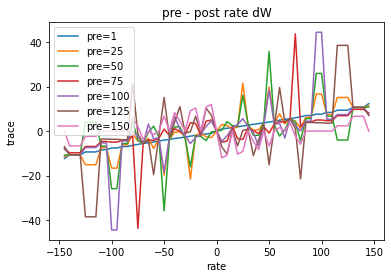

In [7]:
## vs Presynaptic rate w/ offset
config = {
    'n_neurons': 2,
    'n_inputs': 0,
    'stdp_window': 150,
    'learning_rate': 1,
    'max_weight': 1,
    'trace_decay': 0,
}
w = FakeWeight(**config)
synapses = SYNAPSE(w, **config)

LENGTH = 1000
INHIBITORIES = np.array([1, 1])

RATES = [1, 25, 50, 75, 100, 125, 150]  # hz, number of fires / interval -- evenly spaced

for rate2 in RATES:
    X, Y = [], []
    X_minus, Y_minus = [], []

    for rate1 in np.arange(5, 150, 5):
        w.matrix[:, :] = 0
        synapses.reset()
        synapses.reward(1)


        a = np.zeros(LENGTH)
        a[3::LENGTH // rate1] = 1.

        b = np.zeros(LENGTH)
        b[::LENGTH // rate2] = 1.

        full_spike_log = np.array([a, b]).T
        for i in range(1, LENGTH):
            synapses._apply_stdp(full_spike_log[:i], INHIBITORIES)

        X_minus.append(-rate1)
        Y_minus.append(w.matrix[0, 1])
        X.append(rate1)
        Y.append(w.matrix[1, 0])

    plt.plot(X_minus[::-1] + X, Y_minus[::-1] + Y, label=f"pre={rate2}")

plt.title(f"pre - post rate dW")
plt.xlabel('rate')
plt.ylabel('trace')
plt.legend()

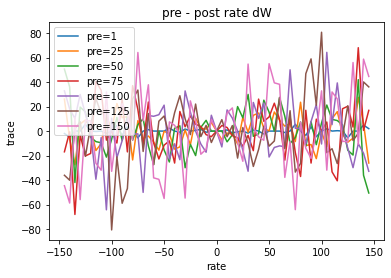

In [16]:
## vs Presynaptic rate - Uniform Rates
# ideally uniform will be a flat line, any randomness should create all possible coincidences
config = {
    'n_neurons': 2,
    'n_inputs': 0,
    'stdp_window': 150,
    'learning_rate': 1,
    'max_weight': 1,
    'trace_decay': 0,
}
w = FakeWeight(**config)
synapses = SYNAPSE(w, **config)

LENGTH = 1000
INHIBITORIES = np.array([1, 1])

RATES = [1, 25, 50, 75, 100, 125, 150]  # hz, number of fires / interval -- evenly spaced

for rate2 in RATES:
    X, Y = [], []
    X_minus, Y_minus = [], []

    for rate1 in np.arange(5, 150, 5):
        w.matrix[:, :] = 0.
        synapses.reset()
        synapses.reward(1)

        a = np.float_(np.random.uniform(0, 1, size=LENGTH) <= rate1 / LENGTH)
        b = np.float_(np.random.uniform(0, 1, size=LENGTH) <= rate2 / LENGTH)

        full_spike_log = np.array([a, b]).T

        for i in range(1, LENGTH):
            synapses._apply_stdp(full_spike_log[:i], INHIBITORIES)

        X_minus.append(-rate1)
        Y_minus.append(w.matrix[0, 1])
        X.append(rate1)
        Y.append(w.matrix[1, 0])

    plt.plot(X_minus[::-1] + X, Y_minus[::-1] + Y, label=f"pre={rate2}")
    # plt.plot(np.unique(X), np.poly1d(np.polyfit(X, Y, 1))(np.unique(X)), label=f"pre={rate2}")

plt.title(f"pre - post rate dW")
plt.xlabel('rate')
plt.ylabel('trace')
plt.legend()

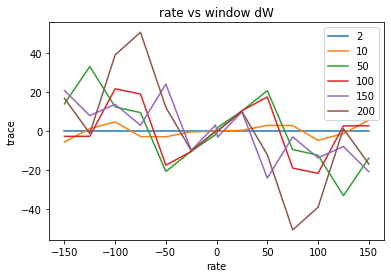

In [17]:
## vs STDP Window - Uniform Rates
# ideally uniform will be a flat line, any randomness should create all possible coincidences
LENGTH = 1000
INHIBITORIES = np.array([1, 1])

RATES = [1, 25, 50, 75, 100, 125, 150]

for window in [2, 10, 50, 100, 150, 200]:
    config = {
        'n_neurons': 2,
        'n_inputs': 0,
        'stdp_window': window,
        'learning_rate': 1,
        'max_weight': 1,
        'trace_decay': 0,
    }
    w = FakeWeight(**config)
    synapses = SYNAPSE(w, **config)

    X, Y = [], []
    X_minus, Y_minus = [], []

    for rate in RATES:
        w.matrix[:, :] = 0
        synapses.reset()
        synapses.reward(1)

        a = np.float_(np.random.uniform(0, 1, size=LENGTH) <= rate / LENGTH)
        b = np.float_(np.random.uniform(0, 1, size=LENGTH) <= 100 / LENGTH)

        full_spike_log = np.array([a, b]).T

        for i in range(1, LENGTH):
            synapses._apply_stdp(full_spike_log[:i], INHIBITORIES)

        X_minus.append(-rate)
        Y_minus.append(w.matrix[0, 1])
        X.append(rate)
        Y.append(w.matrix[1, 0])

    plt.plot(X_minus[::-1] + X, Y_minus[::-1] + Y, label=f"{window}")

plt.title(f"rate vs window dW")
plt.xlabel('rate')
plt.ylabel('trace')
plt.legend()